TO DO : compare oversampling with SMOTE vs. with ROS
TO DO: FUll python "use case
    "

In [87]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as metrics

import os

import eli5

from sklearn import tree
import graphviz

from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

import shap

import warnings

import scipy as sp

import lime
from lime import lime_tabular
import lightgbm as lgb
import seaborn as sns

import imblearn

In [2]:
os.listdir("../data/alge_data/")

['epoct_ezvir_05dec2018_dictionary.csv',
 'epoct_ezvir_05dec2018_labeled.csv',
 'epoct_ezvir_05dec2018_unlabeled - Edit.csv',
 'epoct_ezvir_05dec2018_unlabeled.csv',
 'epoct_ezvir_05dec2018_unlabeled_Jan.csv']

In [88]:
data = pd.read_csv("../data/alge_data/epoct_ezvir_05dec2018_unlabeled_Jan.csv")

In [89]:
data_labels = pd.read_csv("../data/alge_data/epoct_ezvir_05dec2018_dictionary.csv", encoding="unicode_escape")

In [90]:
selected = ["date_season_meteo",
           "dem_age_int",
           "dem_sex",
           "dem_ward_kin",
            "dxlab_malaria_hi",
            "dxlab_malaria_low",
            "lab_malaria_any_d0",
            "sign_measles",
            "sign_pallor",
            "sign_skin_sev",
            "sign_skininf",
            "signv_temp_d0",
            "symp_abdopain",
            "symp_bloodstool",
            "symp_cough",
            "symp_diarrhea",
            "symp_dyspnea",
            "symp_eye",
            "symp_fev24h",
            "symp_liquidstool",
            "symp_pharyngitis",
            "symp_skin",
            "symp_vomit",
            "days_of_fever"
]

In [91]:
data_selected = data[selected]

In [92]:
data_unique = pd.DataFrame([[data_selected.columns[i], data_selected[x].nunique(), data_selected[x].isnull().sum()] for i,x in enumerate(data_selected.columns)],
                          columns = ["name", "nunique","nnull"])
data_unique = data_unique.merge(data_labels, on = "name").drop(["position","type","isnumeric","format"],axis=1)

In [93]:
n_patients=len(data_selected)
n_patients*0.8

2553.6000000000004

In [94]:
data_unique

,name,nunique,nnull,vallab,varlab
0,date_season_meteo,3,0,seasonmeteo,Season according to meteorological data
1,dem_age_int,58,0,NaN,NaN
2,dem_sex,2,0,sex,Sex
3,dem_ward_kin,22,1351,kinondoni,Kinondoni ward
4,dxlab_malaria_hi,2,0,yn,Dx: Malaria hsPCR+/RDT+ = high parasitemia
5,dxlab_malaria_low,2,0,yn,Dx: Malaria hsPCR+/RDT- = low parasitemia
6,lab_malaria_any_d0,2,192,NaN,LAB: Any malaria positive test (mRDT or hsmRDT...
7,sign_measles,2,92,yn,Sign: Any sign of measles infection (d0-d3)
8,sign_pallor,2,0,yn,Sign: Any sign of anemia (d0-d3)
9,sign_skin_sev,2,0,yn,Sign: Severe skin or soft tissue infection (d0...


In [95]:
data_selected.date_season_meteo.unique()

array([2, 1, 3], dtype=int64)

In [96]:
data_selected.dropna(axis=1,thresh=n_patients*0.8, inplace=True)
data_selected.fillna(data_selected.median(), inplace=True)

In [97]:
data_selected.isnull().any().any()

False

In [98]:
data_selected["lab_malaria_any_d0"].value_counts()

0.0    2872
1.0     320
Name: lab_malaria_any_d0, dtype: int64

In [99]:
data_selected.columns

Index(['date_season_meteo', 'dem_age_int', 'dem_sex', 'dxlab_malaria_hi',
       'dxlab_malaria_low', 'lab_malaria_any_d0', 'sign_measles',
       'sign_pallor', 'sign_skin_sev', 'sign_skininf', 'signv_temp_d0',
       'symp_abdopain', 'symp_bloodstool', 'symp_cough', 'symp_diarrhea',
       'symp_dyspnea', 'symp_eye', 'symp_fev24h', 'symp_pharyngitis',
       'symp_skin', 'symp_vomit', 'days_of_fever'],
      dtype='object')

In [100]:
non_categorical = ["dem_age_int", "signv_temp_d0"]
null_values = ["symp_liquidstool","dem_ward_kin"]
non_binary = ["date_season_meteo"]
confounding = ["dxlab_malaria_hi","dxlab_malaria_low"]
categorical = list(set(selected)-set(non_categorical)-set(null_values)-set(non_binary)-set(confounding))

In [101]:
le = LabelEncoder()
data_ml = data_selected[categorical]
data_ml = data_ml.apply(le.fit_transform)
data_ml = pd.get_dummies(data_selected["date_season_meteo"], prefix="date_season_meteo"\
              ).merge(data_ml, left_index=True, right_index=True\
                    ).merge(data_selected[["dem_age_int","signv_temp_d0"]], left_index=True, right_index=True)

In [102]:
all_categorical = categorical+["date_season_meteo_1","date_season_meteo_2","date_season_meteo_3"]

In [103]:
from sklearn.decomposition import PCA

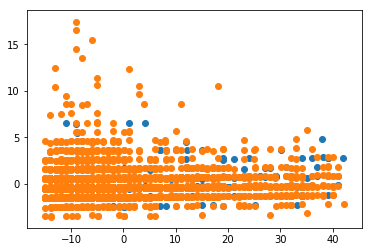

In [125]:
pca = PCA(n_components=2)
pcaX = pca.fit_transform(X)


plt.scatter(pcaX[np.ravel(y)==1,0],pcaX[np.ravel(y)==1,1])
plt.scatter(pcaX[np.ravel(y)==0,0],pcaX[np.ravel(y)==0,1])

In [105]:
from imblearn.over_sampling import RandomOverSampler

In [127]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y["lab_malaria_any_d0"])

In [150]:
X_ros=pd.DataFrame(X_ros, columns=X.columns)
y_ros=pd.DataFrame(y_ros,columns=["lab_malaria_any_d0"])

for over sampling under sampling techniques


https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/applications/plot_over_sampling_benchmark_lfw.html


In [151]:
y_label= ["lab_malaria_any_d0"]
X_labels = list(set(data_ml.columns)-set(y_label))

X = data_ml[X_labels]
y = data_ml[y_label]

train_X, val_X, train_y, val_y = train_test_split(X_ros, y_ros, random_state=1)

In [152]:
model_forest = RandomForestClassifier(n_estimators=100, random_state=0).fit(train_X, np.ravel(train_y))

In [153]:
model_forest_preds = model_forest.predict(val_X)
accuracy = metrics.accuracy_score(model_forest_preds,val_y)
precision = metrics.precision_score(model_forest_preds,val_y)
recall = metrics.recall_score(model_forest_preds,val_y)

In [154]:
print("accuracy {} \nprecision {} \nrecall {}".format(accuracy, precision, recall))

accuracy 0.9700557103064067 
precision 1.0 
recall 0.9418132611637348


In [155]:
confusion_matrix = metrics.confusion_matrix(model_forest_preds, val_y)

In [156]:
# lab_malaria_any_d0	2	192	NaN	LAB: Any malaria positive test (mRDT or hsmRDT...

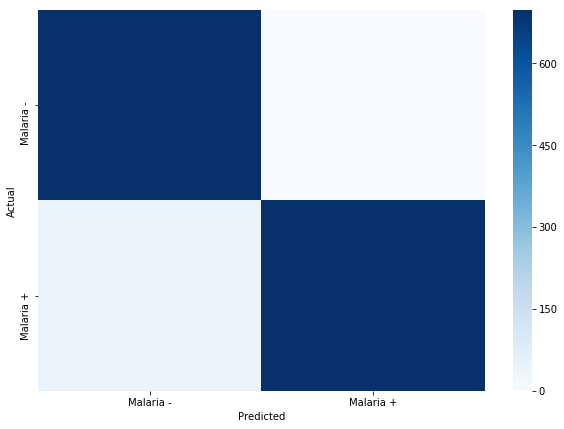

In [157]:
confusion_matrix_plot = pd.DataFrame(confusion_matrix, 
                                    columns=["Malaria -","Malaria +"],
                                    index =["Malaria -", "Malaria +"])
fig=plt.subplots(figsize=(10,7))
confusion_matrix_plot.index.name = 'Actual'
confusion_matrix_plot.columns.name = 'Predicted'
sns.heatmap(confusion_matrix_plot, cmap="Blues")


In [158]:
tn, fp, fn, tp = np.ravel(confusion_matrix)

In [159]:
# https://medium.com/@kunanba/what-is-roc-auc-and-how-to-visualize-it-in-python-f35708206663
# only select [:,1] == probabilities for the positive class ONLY
probas = model_forest.predict_proba(val_X)[:, 1]
def get_preds(threshold, probabilities):
    return [1 if prob > threshold else 0 for prob in probabilities]

In [160]:
roc_values = []
specificities, sensitivities = [],[]
for thresh in np.linspace(0, 1, 100):
    preds = get_preds(thresh, probas)
    tn, fp, fn, tp = np.ravel(metrics.confusion_matrix(val_y, preds))
    tpr = tp/(tp+fn) #recall/sensitivity
    fpr = fp/(fp+tn)
    specificity = tn/(tn+fp)
    sensitivity = tp/(tp+fn)
    
    roc_values.append([tpr, fpr])
    specificities.append(specificity)
    sensitivities.append(sensitivity)
tpr_values, fpr_values = zip(*roc_values)

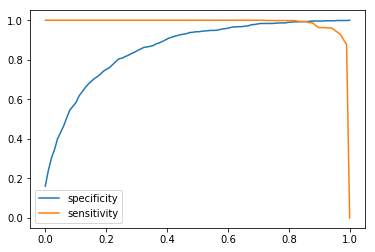

In [161]:
plt.plot(np.linspace(0, 1, 100),specificities, label="specificity")
plt.plot(np.linspace(0, 1, 100),sensitivities, label ="sensitivity")
plt.legend()

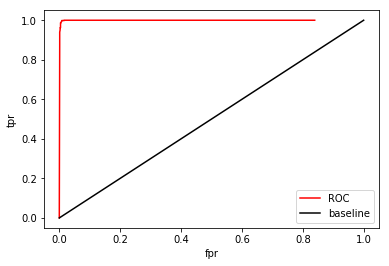

In [162]:
plt.plot(fpr_values, tpr_values, label="ROC", color = "red")
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),label="baseline", color="black")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()

In [163]:
metrics.roc_auc_score(val_y, model_forest_preds)


0.970945945945946

In [164]:
perm = eli5.sklearn.PermutationImportance(model_forest, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.2701 ± 0.0254,signv_temp_d0
0.2468 ± 0.0276,dem_age_int
0.1297 ± 0.0118,symp_cough
0.1283 ± 0.0052,days_of_fever
0.1157 ± 0.0101,date_season_meteo_3
0.0993 ± 0.0133,dem_sex
0.0940 ± 0.0088,symp_fev24h
0.0762 ± 0.0112,symp_vomit
0.0518 ± 0.0065,symp_diarrhea
0.0270 ± 0.0055,symp_abdopain


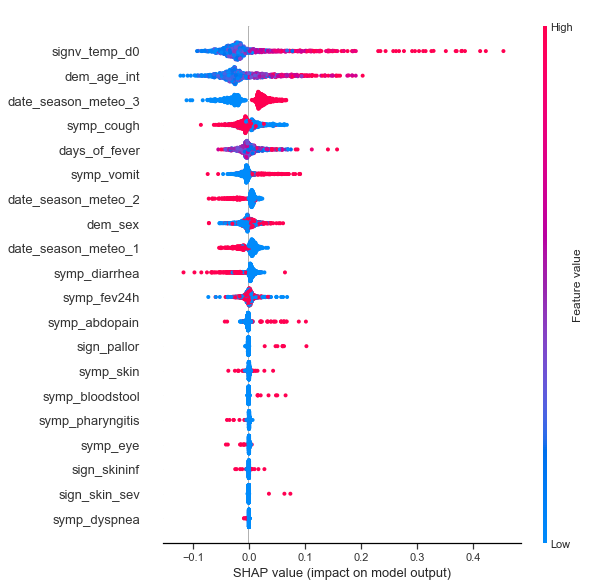

In [795]:
shap_explainer = shap.TreeExplainer(model_forest)
shap_values = shap_explainer.shap_values(val_X)
shap.summary_plot(shap_values[1], val_X)

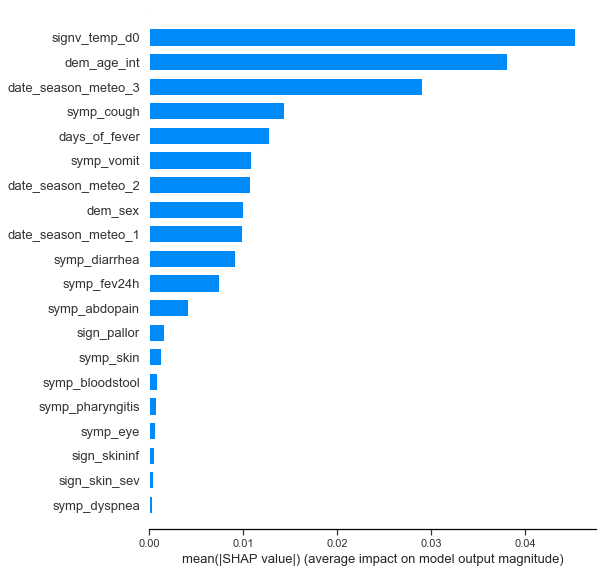

In [796]:
shap.summary_plot(shap_values[1], val_X, plot_type = "bar")

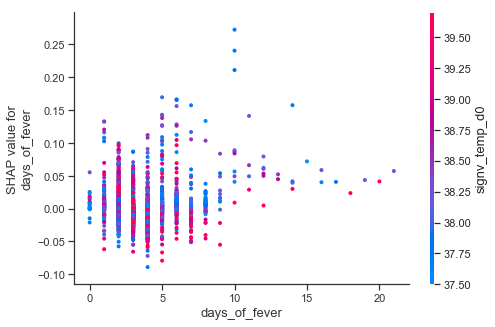

In [797]:
shap_values = shap_explainer.shap_values(X)
shap.dependence_plot("days_of_fever", shap_values[1], X, interaction_index = "signv_temp_d0")

In [798]:
lime_explainer= lime.lime_tabular.LimeTabularExplainer(np.array(train_X),
                                                 feature_names=X_labels,
                                                 categorical_features=all_categorical,
                                                 mode="classification")

In [799]:
predict_fn_rf = lambda x: model_forest.predict_proba(x).astype(float)
X = train_X.values
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X,
                                                   feature_names = train_X.columns,
                                                   class_names=['Malaria Negative','Malaria Positive'],
                                                   kernel_width=5)


In [800]:
exp = lime_explainer.explain_instance(val_X.iloc[0], predict_fn_rf)
exp.show_in_notebook()

In [801]:
val_y.iloc[0]


lab_malaria_any_d0    0
Name: 2865, dtype: int64

In [802]:
exp = lime_explainer.explain_instance(val_X.iloc[101], predict_fn_rf)
exp.show_in_notebook()

In [803]:
val_y.iloc[101]

lab_malaria_any_d0    1
Name: 1151, dtype: int64

## caution:
- DOES it make sense to split / bin based on probability of prediction of being +?
    - WHY DIFFICULT CHOICE? because when we plot precision / else: these are threshold based, might mess up right along the threshold...
- make 10 categories based on probability of being malaria +
- categories are threshold based so 90+ % chance, etc -=> not all have the same number of patients
- still no category should have too little patients
- instead of runnnig the spec / sens curve for rando shit, do it for "groups" of patients according to their separation threshold
- plot, with barplot as number of ppl per group, and their real diagnosis

In [165]:
probas = model_forest.predict_proba(val_X)
preds = pd.DataFrame(model_forest.predict(val_X))
# need to compare to val_y

In [166]:
malaria_pos = pd.DataFrame(np.column_stack((probas[:,1], preds)), columns =  ["malaria_positive_score","preds"])
malaria_pos = malaria_pos.merge(val_y, left_index=True, right_index=True)
malaria_pos.rename({"lab_malaria_any_d0":"malaria_positive_TRUTH"}, axis=1, inplace=True)
malaria_pos = malaria_pos.merge(val_X, left_index=True, right_index=True)
malaria_pos.sort_values("malaria_positive_score", ascending = False, inplace=True)

## CAUTION
- in this dataset, no value found for proba positive malaira > 0.9 so the last bin is empty to there are only 4 groups...

In [175]:
bins = [-np.inf, 0.2, 0.4, 0.6, 0.8, np.inf]
# bins= [-np.inf, 0.5, np.inf]
binlabels=[1,2,3,4,5]
# binlabels=[1,2]
malaria_pos["binned"] = pd.cut(malaria_pos["malaria_positive_score"], bins=bins, labels=binlabels)

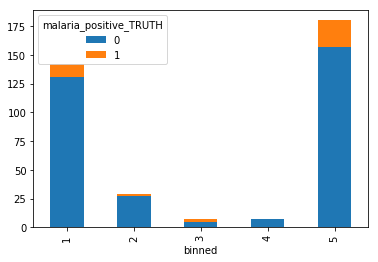

In [168]:
malaria_pos.groupby(["binned","malaria_positive_TRUTH"]).size().unstack().plot.bar(stacked=True)

## CAUTION CAUTION CAUTION
threshold for binary choice = 0.5
KEEP THAT IN MIND WHEN LOOKING AT BINS, 
we binned acoording to "proba" of predictions. If proba is at 0.5, it is sort of half half between would declare positive and owuld declare negative

- above: blue = you are malaria NEGATIVE; orange = you are malaria POSITIVE  
- binned = 1 2 3 4 "severity" score: based on model prediction probability of "positive": basically if =4, the prediction probability was in the bin 0.8,1.01 (since 1.0 would cut out the 100% chance)

wechose preds[0,1] the label is "POSITIVE" so pred 0 = negative

PER BIN : the malaria_positive_TRUTH = label

    preds = pred for POSITIVE malaria

In [169]:
gb = malaria_pos.groupby(["binned"])
bins= gb.apply(lambda grp: np.ravel(metrics.confusion_matrix(grp.preds,grp.malaria_positive_TRUTH)))

TO DO : specificity and precision on the WHOLE dataset but with the thresholds from the bins

In [177]:
# only select [:,1] == probabilities for the positive class ONLY
probas = model_forest.predict_proba(val_X)[:, 1]

In [198]:
sens,spec=[],[]
bins[0]=0
bins[-1]=1
for thresh in bins:
    preds=get_preds(thresh, probas)
    tn, fp, fn, tp = np.ravel(metrics.confusion_matrix(val_y, preds))
    spec_temp = tn/(tn+fp)
    sens_temp = tp/(tp+fn)
    spec.append(spec_temp*100)
    sens.append(sens_temp*100)
spec.pop();sens.pop();

In [195]:
t= malaria_pos.groupby(["binned","malaria_positive_TRUTH"]).size().unstack()
t= t.reset_index(drop=True).rename({0:"positive_TRUTH=0", 1:"positive_TRUTH=1"},axis=1)
t["positive_TRUTH=1"].fillna(0., inplace=True)
t.reset_index(inplace=True)

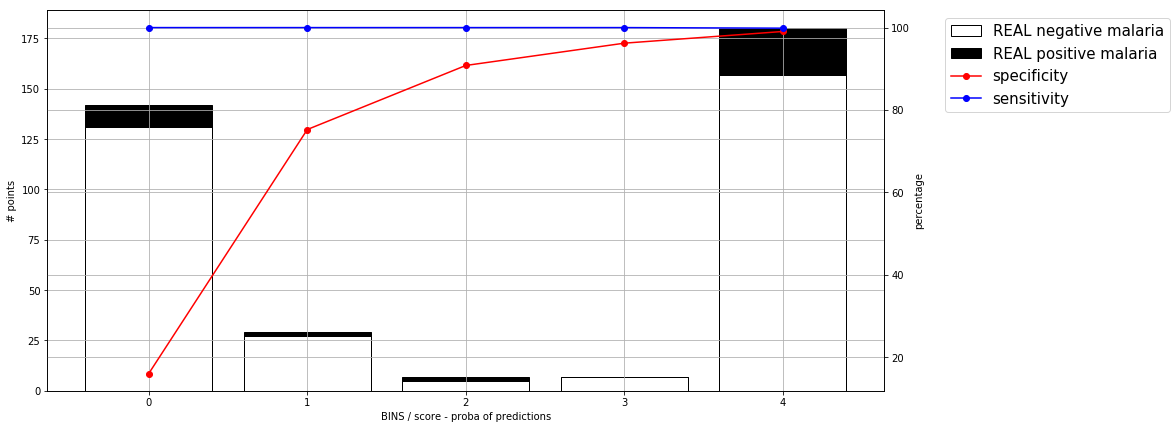

In [205]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams['axes.facecolor'] = 'white'



fig, ax1 = plt.subplots(figsize=(15,7))
b1=ax1.bar(x=t["index"],height=t["positive_TRUTH=0"], color="white", edgecolor="black", label="REAL negative malaria",zorder=-1)
b2=ax1.bar(x=t["index"], height=t["positive_TRUTH=1"],bottom=t["positive_TRUTH=0"], color="black", edgecolor="black", label = "REAL positive malaria",zorder=-1)

ax1.set_xlabel("BINS / score - proba of predictions")
ax1.set_ylabel("# points")


ax2 = ax1.twinx()

p1=ax2.plot(np.linspace(0,4,5),spec, "ro-",label = "specificity")
p2=ax2.plot(np.linspace(0,4,5),sens, "bo-", label = "sensitivity")

ax2.set_ylabel("percentage")


lines1, labels1 = ax1.get_legend_handles_labels()

lines2, labels2 = ax2.get_legend_handles_labels()

ax2.legend(lines1 + lines2, labels1 + labels2, loc=1, bbox_to_anchor=(1.35,1), fontsize=15)

ax1.grid(None)
ax2.grid(None)
plt.show()

labels are off on x axis actually, should score from 1 to 5 to 0 to 4

In [221]:
pca = PCA(n_components=2)
toPCA = malaria_pos[X_labels]
pcaX = pca.fit_transform(toPCA)




In [224]:
plt.scatter(pcaX[0])

TypeError: scatter() missing 1 required positional argument: 'y'

In [ ]:
perm = eli5.sklearn.PermutationImportance(model_forest, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

gb = malaria_pos.groupby(["binned"])
bins= gb.apply(lambda grp: )